In [68]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import cv2, os, numpy as np
import matplotlib.pyplot as plt
import json

## Instantiating and loading and the MaskRCNN model with pretrained coco weights

In [ ]:
class Config(Config):
    NAME = "demo"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 81
config = Config()
model = modellib.MaskRCNN(mode="inference", model_dir=os.getcwd(), config=config)
model.load_weights('mask_rcnn_coco.h5', by_name=True)

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Creating mappings for coco dataset, class_id -> class_name and vise-versa

In [ ]:
class_idx = {x:i for i, x in enumerate(class_names)}
idx_class = {i:x for i, x in enumerate(class_names)}

## Loading the sample input image and the corresponding labelled iamge

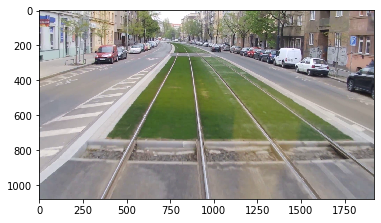

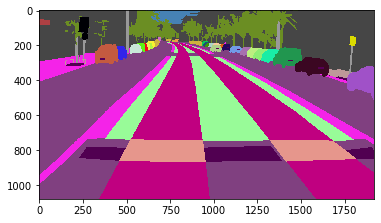

In [164]:
IMAGE_PATH = 'input_image.png'
ANNOTATION_PATH = 'annotated_image.png'
src_img = cv2.cvtColor(cv2.imread(IMAGE_PATH), cv2.COLOR_RGB2BGR)
src_annotation = cv2.cvtColor(cv2.imread(ANNOTATION_PATH), cv2.COLOR_RGB2BGR)
with open('legend.json') as f:
    legend = json.load(f)
color_map = {tuple(int(hex_color.strip('#')[i:i+2], 16) for i in (0, 2, 4)):class_name for hex_color, class_name in legend['legend'].items()}    
plt.figure()
plt.imshow(src_img)
plt.figure()
plt.imshow(src_annotation)

## Getting the predictions from the MaskRCNN model

In [17]:
raw_predictions = model.detect(images=[src_img], verbose=1)

masks = raw_predictions[0]['masks']
rois = raw_predictions[0]['rois']
class_ids = raw_predictions[0]['class_ids']

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


## Normalizing the class names to match the coco dataset
 - Some classes may have multiple instances, and others might not
 - We maintain two separate lists to keep track of them

In [248]:
def mapping(class_name):
    """return coco class name for a given custom class name"""
    class_name_lower = class_name.lower()
    if 'car' in class_name_lower:
        return 'car'
    elif 'truck' in class_name_lower:
        return 'truck'
    elif 'motorcycle' in class_name_lower:
        return 'motorcycle'
    elif 'bus' in class_name_lower:
        return 'bus'
    elif 'person' in class_name_lower:
        return 'person'
    elif 'train' in class_name_lower:
        return 'train'    
    else:
        return class_name
    
instances_classes = ['Bus', 'Bus # 1', 'Car', 'Car # 1', 'Car # 10', 'Car # 11', 'Car # 12', 'Car # 13', 'Car # 14', 'Car # 15', 'Car # 16', 'Car # 17', 'Car # 18', 'Car # 19', 'Car # 2', 'Car # 20', 'Car # 21', 'Car # 22', 'Car # 23', 'Car # 24', 'Car # 3', 'Car # 4', 'Car # 5', 'Car # 6', 'Car # 7', 'Car # 8', 'Car # 9', 'Caravan', 'Caravan # 1', 'Truck', 'Truck # 1', 'Truck # 2']
non_instance_classes = ['mountain', 'static', 'ego_vehicle', 'rectification_border', 'Motorcycle', 'building', 'sky', 'ground', 'cycle', 'Person', 'person_group', 'licenseplate', 'wall', 'vegetation', 'dynamic', 'road', 'bridge', 'tunnel', 'terrain', 'pole', 'billboard', 'guardrail', 'fence', 'tram track', 'car_group', 'street light', 'traffic_sign', 'Train', 'rail track', 'Trailer', 'sidewalk', 'cycle_group', 'traffic_light', 'parking', 'rider', 'unlabeled']    

## Steps followed to calculate the pixel wise accuracy for each object instance
 - Convert the hex color code to RGB, which is easier to work with
 - For each object instance
   - Get the ground truth (labelled by annotators) mask for object instance, identified uniquely by the RGB color code.
   - Extract the pixels from the predictions array from the same roi as that of the mask got in the previous step.
   - Use the channel with the maximum number of foreground prediction, this can be done by summing the prediction array along the first axis and then picking the index with maximum sum.
   - Keep track of the channels that are previously used.
   - The required prediction mask for the current object instance can then be got from the prediction array by using the channel got in the previous step.
   - Compute the pixel wise accuracy with the formula.
   <a href="https://www.codecogs.com/eqnedit.php?latex=\inline&space;accuracy=\frac{TP&plus;TN}{TP&plus;TN&plus;FP&plus;FN}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\inline&space;accuracy=\frac{TP&plus;TN}{TP&plus;TN&plus;FP&plus;FN}" title="accuracy=\frac{TP+TN}{TP+TN+FP+FN}" /></a>
    - TP represents foreground pixels that are correctly predicted
    - TN represents background pixels that are correctly predicted
    - FP represents background pixels that are wrongly predicted
    - FN represents foreground pixels that are wrongle predictes
  - The accuracy formula can be simplfied to (correctly classified pixels) / (total pixels). This can be computed using element wise comparision with the ground truth, and then taking the mean along first axis
  - Get the predicted class name using the channel to index the class_ids list.
  - If the normalized class name and predicted class name do no match, set accuracy to zero.
  - If the current channel has already be used by a previous object
   - Set the accuracy to 0 if the respective class in present in the multiple instance class list

In [242]:
# def get_mask_at_roi(roi, raw_mask_array):
#     """returns mask at the given roi
#     roi : should be in the following format y1, x1, y2, x2
#     """
#     x1, y1, x2, y2 = roi[1], roi[0], roi[3], roi[2]
#     roi_mask = masks[y1:y2, x1:x2, ...]
#     return np.sum(roi_mask, axis=-1)

def get_mask_for_color_code(color_code, annotation):
    """given a color code, returns the mask of the corresponding object"""
    return np.all(annotation == color_code, axis=-1)    

def calculate_pixel_accuracy(labelled_mask, label_class, prediction_array):
    accuracy = 0
    predicted_mask_array = prediction_array[labelled_mask]
    p_sum = np.sum(predicted_mask_array, axis=0)
    if np.sum(p_sum) == 0:
        return -1
    predicted_channel_id = np.argmax(p_sum, axis=0)
    predicted_mask = masks[..., predicted_channel_id]
    predicted_class = idx_class[class_ids[predicted_channel_id]]
    correct_pixels = predicted_mask == labelled_mask
    if (predicted_class == mapping(label_class)):
        if predicted_channel_id in seen_idx:
            if label_class not in instances_classes:
                accuracy = np.mean(correct_pixels)
        else:
            accuracy = np.mean(correct_pixels)
    return accuracy

result_dict = {}
seen_idx = {}

for color_code, class_name in color_map.items():
    labelled_mask = get_mask_for_color_code(color_code, src_annotation)
    accuracy = calculate_pixel_accuracy(labelled_mask, class_name, masks)
    if accuracy == -1:
        continue
    result_dict[class_name] = accuracy

## Writing the output to a json file

In [240]:
with open('output.json', 'w') as f:
    json.dump(result_dict, f)